In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, PowerTransformer, Normalizer, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_score, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

import math
import joblib 
import datetime

import warnings
warnings.filterwarnings('ignore')

### 1. Get data

In [2]:
# data

# import data
df = pd.read_csv('../../#task4-eda/datasets/OUTPUT_WBI_exposer_cyclones_v14.csv', sep=';')
df_trans = df.copy()
df_trans['TOTAL_AFFECTED'] = df_trans['TOTAL_AFFECTED'].apply(lambda x: np.log(x))

# separate X and y
X = df.drop(['TOTAL_AFFECTED'], axis=1)
y = df['TOTAL_AFFECTED']
y_trans = df['TOTAL_AFFECTED'].apply(lambda x: np.log(x))

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# types of features
num_features = list(X.loc[:, df.dtypes != object].columns)
cat_features = list(X.loc[:, df.dtypes == object].columns)

### 2. Analyze data

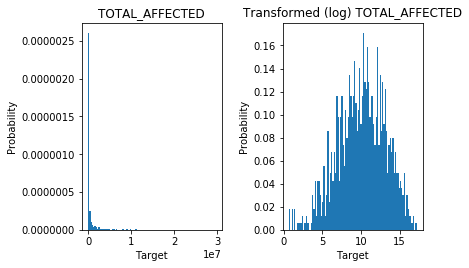

In [3]:
# distribution of target TOTAL_AFFECTED --> should use y_trans = log(y)

f, (ax0, ax1) = plt.subplots(1, 2)
f.tight_layout(pad=3.0)


ax0.hist(y, bins=100, density= True)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('TOTAL_AFFECTED')

ax1.hist(y_trans, bins=100, density= True)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed (log) TOTAL_AFFECTED');

In [4]:
df_trans.head()

,SID,NAME,ISO,YEAR,COORDS,COORDS_MAX_WINDS,COORDS_MIN_DIST2LAND,BASIN,SUB BASIN,MONTH_START,MONTH_END,DATE_START,DATE_END,DATE_LAND_START,DATE_LAND_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,NATURE,GENERAL_CATEGORY,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,MAX_USA_SSHS_INLAND,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,POP_DEN_SQ_KM,RURAL_POP(%),HDI,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),Income_level_Final,POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
0,1949163N07145,DELLA,JPN,1949,"[(21.5, 125.424), (22.2, 125.8), (22.9089, 126...","[(27.6584, 128.82), (28.9141, 129.572999999999...","[(31.9866, 130.683), (33.5183, 130.97299999999...",WP,WP,6,6,19/06/1949 9:00,24/06/1949 6:00,20/06/1949 15:00,23/06/1949 3:00,117.0,60.0,TS,Cat 4,116.0,952,0,33.0,3,0,99.82,3889.480640,3632.626180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,419.0,195.0,77.20,0.816,0.059615,4173.5,67.79,8607.657082,0.0,67.666098,2.867878,Low,1.198300e+07,5.803981e+06,3.320907e+06,12.175851
1,1950241N23140,JANE,JPN,1950,"[(23.8845, 139.74), (23.9335, 139.639), (23.98...","[(28.7509, 133.748), (29.1201, 133.762), (29.6...","[(34.9374, 135.476), (36.1016, 136.095), (37.2...",WP,WP,8,9,30/08/1950 3:00,05/09/1950 0:00,03/09/1950 3:00,04/09/1950 0:00,141.0,21.0,ET,Cat 4,116.0,940,0,31.0,3,1,99.82,3596.090691,2787.480021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,509.0,227.0,47.00,0.816,0.059615,4173.5,67.79,8607.657082,0.0,67.666098,2.867878,Low,3.160822e+07,1.559196e+07,1.018936e+07,13.372526
2,1951224N12316,CHARLIE,JAM,1951,"[(17.3398, -75.4138), (17.6, -76.2), (17.9, -7...","[(17.6, -76.2), (17.9, -76.9)]","[(17.9, -76.9), (18.1, -77.8)]",NAm,CS,8,8,17/08/1951 21:00,18/08/1951 12:00,18/08/1951 3:00,18/08/1951 6:00,15.0,3.0,TS,Cat 3,110.0,0,0,17.0,3,3,132.40,438.214691,435.729082,2788659.0,2788659.0,2552903.0,2.148198e+10,2.148198e+10,1.948346e+10,56000.0,154.0,133.0,66.23,0.668,0.100541,868.3,69.93,3796.219401,0.0,64.770000,2.578304,Low,1.689243e+06,1.687083e+06,1.195052e+06,9.913438
3,1951337N09150,AMY,PHL,1951,"[(12.0725, 130.967), (12.1333, 130.517), (12.1...","[(11.7833, 127.9)]","[(10.7333, 124.8), (10.534, 123.174), (10.6833...",WP,WP,12,12,07/12/1951 9:00,17/12/1951 0:00,09/12/1951 12:00,11/12/1951 0:00,231.0,36.0,TS,Cat 4,120.0,924,0,11.0,4,2,119.20,2238.058669,1905.587795,20464826.0,12675908.0,5618193.0,1.131050e+11,1.880280e+11,4.897333e+10,NaN,569.0,64.5,75.35,0.590,0.180442,996.3,25.68,1059.467412,0.0,61.105000,2.757732,Low_Middle,4.760039e+06,3.006670e+06,1.114774e+06,11.002100
4,1952180N05144,EMMA,PHL,1952,"[(9.33776, 130.185), (9.38633, 129.61), (9.45,...","[(9.45, 129.017), (9.50407, 128.407), (9.56613...","[(10.4667, 123.867), (10.6492, 123.239), (10.8...",WP,WP,7,7,01/07/1952 6:00,04/07/1952 18:00,02/07/1952 12:00,02/07/1952 21:00,84.0,9.0,TS,Cat 3,110.0,968,0,15.0,3,1,110691.00,1876.186790,1797.712213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,66.9,72.41,0.590,0.180442,996.3,25.68,1059.467412,0.0,61.105000,2.757732,Low_Middle,5.130796e+06,2.789486e+06,1.988524e+06,4.634729


In [5]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 51 columns):
SID                                                   991 non-null object
NAME                                                  991 non-null object
ISO                                                   991 non-null object
YEAR                                                  991 non-null int64
COORDS                                                991 non-null object
COORDS_MAX_WINDS                                      991 non-null object
COORDS_MIN_DIST2LAND                                  991 non-null object
BASIN                                                 991 non-null object
SUB BASIN                                             991 non-null object
MONTH_START                                           991 non-null int64
MONTH_END                                             991 non-null int64
DATE_START                                            991 non-null object
DATE_END  

In [6]:
df_trans.describe()

,YEAR,MONTH_START,MONTH_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,POP_DEN_SQ_KM,RURAL_POP(%),HDI,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,989.000000,991.000000,991.000000,991.000000,991.000000,7.610000e+02,7.610000e+02,7.610000e+02,7.600000e+02,7.600000e+02,7.600000e+02,6.780000e+02,861.000000,991.000000,991.000000,991.000000,990.000000,981.000000,987.000000,982.000000,9.910000e+02,987.000000,981.000000,9.110000e+02,9.110000e+02,9.110000e+02,991.000000
mean,1999.789102,7.770938,7.833502,89.267238,20.097713,86.881699,939.110999,16.533804,18.303832,1.776993,201.798799,1531.223549,1223.714571,1.610227e+07,4.809453e+06,8.862758e+05,2.712355e+11,8.280386e+11,4.284908e+10,1.356913e+06,288.731707,196.164857,47.572624,0.669226,0.191490,3501.024220,93.329764,9911.140931,2.150700e+07,70.304835,3.248915,2.770093e+07,1.504009e+07,5.948569e+06,10.086995
std,14.508337,2.766138,2.781165,73.284572,35.257498,33.635653,137.722579,40.005664,9.563449,1.913196,3513.493750,1131.468382,842.425704,1.922866e+07,8.423425e+06,2.824778e+06,6.881936e+11,1.697579e+12,1.718552e+11,7.512798e+06,4764.259321,176.313138,21.898244,0.136769,0.353515,1725.269712,29.318225,15185.727417,2.667692e+07,7.495767,1.864046,4.367805e+07,2.775383e+07,1.159195e+07,3.102598
min,1949.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,30.000000,0.000000,0.000000,1.528000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1.000000,1.780000,0.000000,0.217000,0.004410,393.300000,13.360000,141.276363,-2.000000e+04,41.762000,0.538881,0.000000e+00,0.000000e+00,0.000000e+00,0.693147
25%,1991.000000,7.000000,7.000000,33.000000,0.000000,60.000000,937.000000,0.000000,13.000000,0.000000,62.700000,619.385014,512.093044,1.750572e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.467498e+10,0.000000e+00,1.337775e+04,6.000000,50.400000,24.350000,0.590000,0.059955,2059.700000,76.160000,1412.947077,1.030000e+06,66.511671,1.840000,3.072560e+06,1.057294e+06,2.767477e+05,8.018896
50%,2004.000000,8.000000,9.000000,75.000000,6.000000,85.000000,960.000000,0.000000,16.000000,1.000000,89.800000,1382.779275,1117.129190,8.197178e+06,7.805530e+05,0.000000e+00,8.913770e+09,1.013045e+11,0.000000e+00,7.500000e+04,18.000000,148.000000,53.500000,0.667000,0.094173,3319.800000,98.770000,2605.425404,1.231000e+07,70.802000,2.800000,1.099835e+07,4.367111e+06,1.566158e+06,10.308953
75%,2011.000000,10.000000,10.000000,123.000000,24.000000,115.000000,980.000000,0.000000,21.000000,4.000000,115.300000,2028.372252,1753.531999,2.311566e+07,6.847755e+06,3.018550e+05,1.062160e+11,5.086855e+11,5.002448e+09,4.639975e+05,59.000000,305.000000,65.200000,0.754000,0.193175,4944.900000,113.950000,8918.568543,3.145000e+07,75.087500,4.297143,3.286035e+07,1.691340e+07,5.752552e+06,12.413181
max,2019.000000,12.000000,12.000000,516.000000,333.000000,185.000000,1013.000000,199.000000,69.000000,5.000000,110691.000000,6074.566991,3927.225522,1.186283e+08,6.057264e+07,3.672847e+07,4.629470e+12,9.763580e+12,1.565620e+12,1.250000e+08,138366.000000,1270.000000,92.400000,0.937000,3.069373,8900.000000,202.377089,86150.462210,1.837500e+08,84.099756,14.010000,3.764972e+08,3.222762e+08,1.073686e+08,17.204028


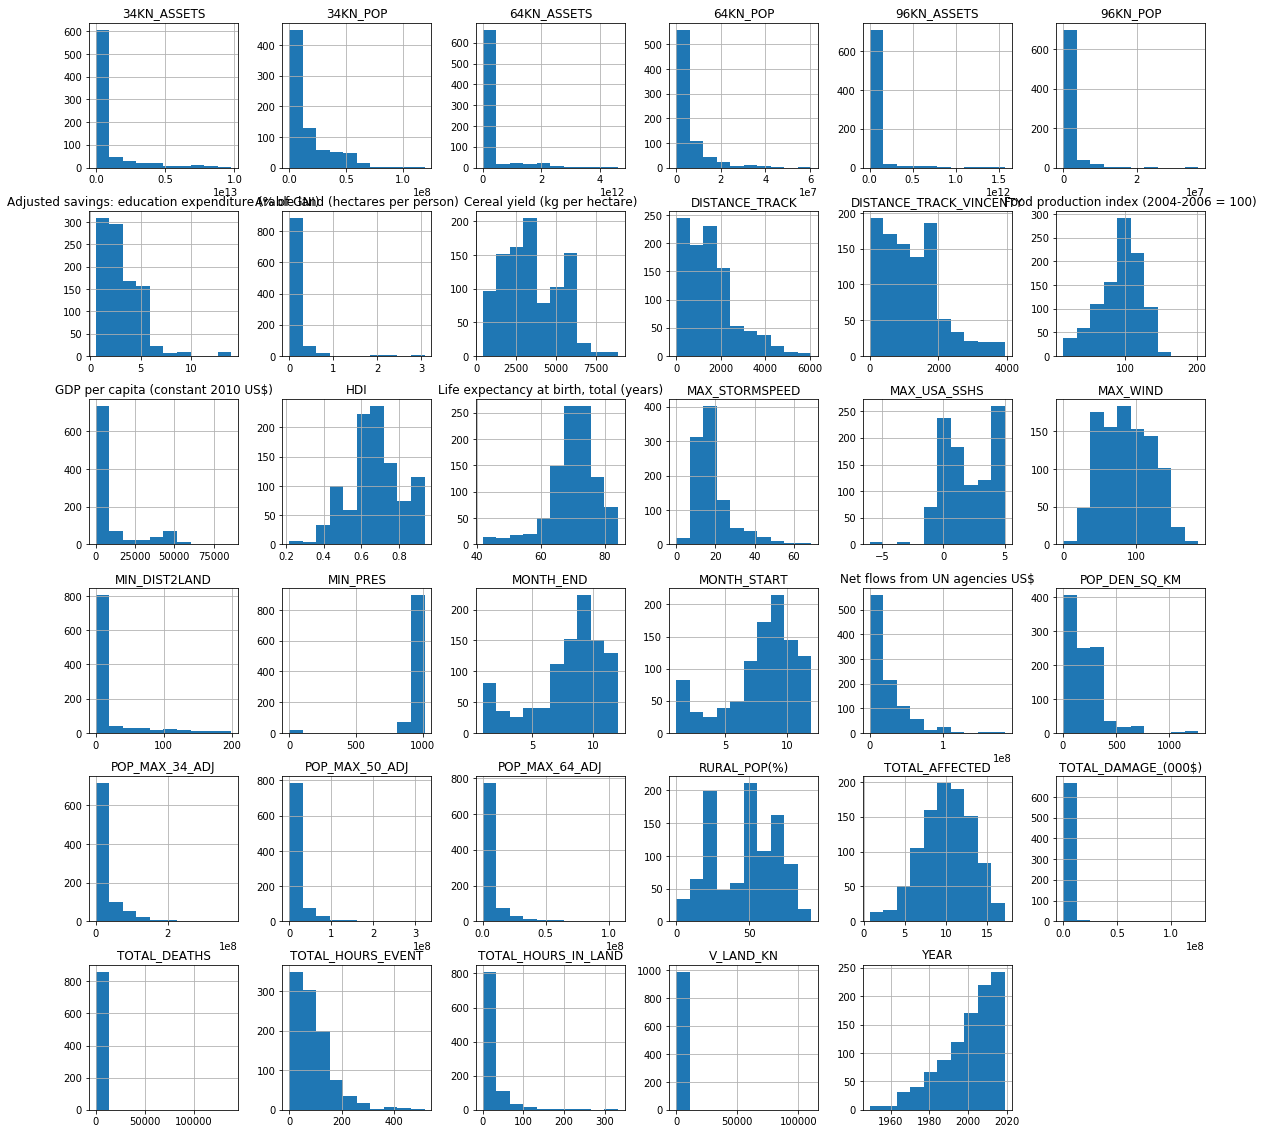

In [7]:
df_trans.hist(figsize = (20,20));

In [8]:
df_trans.corr()

,YEAR,MONTH_START,MONTH_END,TOTAL_HOURS_EVENT,TOTAL_HOURS_IN_LAND,MAX_WIND,MIN_PRES,MIN_DIST2LAND,MAX_STORMSPEED,MAX_USA_SSHS,V_LAND_KN,DISTANCE_TRACK,DISTANCE_TRACK_VINCENTY,34KN_POP,64KN_POP,96KN_POP,64KN_ASSETS,34KN_ASSETS,96KN_ASSETS,TOTAL_DAMAGE_(000$),TOTAL_DEATHS,POP_DEN_SQ_KM,RURAL_POP(%),HDI,Arable land (hectares per person),Cereal yield (kg per hectare),Food production index (2004-2006 = 100),GDP per capita (constant 2010 US$),Net flows from UN agencies US$,"Life expectancy at birth, total (years)",Adjusted savings: education expenditure (% of GNI),POP_MAX_34_ADJ,POP_MAX_50_ADJ,POP_MAX_64_ADJ,TOTAL_AFFECTED
YEAR,1.000000,-0.007472,-0.015591,-0.072913,0.015139,-0.096146,0.242963,0.071397,-0.054606,-0.024040,-0.106016,-0.101112,-0.114085,-0.049679,-0.125758,-0.123720,-0.051778,0.006912,-0.105827,0.109840,0.009274,0.192309,-0.306365,0.299970,-0.031667,0.396499,0.826733,0.162878,0.131786,0.513931,0.125349,0.151970,0.082495,0.171470,0.041372
MONTH_START,-0.007472,1.000000,0.952870,-0.136308,-0.096880,0.094550,0.145447,-0.084002,0.014567,0.117074,-0.008176,-0.102092,-0.043464,0.168919,0.161599,0.137565,0.094052,0.104303,0.074092,0.043384,-0.019360,0.137291,-0.132585,0.167233,-0.229966,0.138071,-0.050461,0.028256,0.051500,0.218983,-0.071883,0.108105,0.101455,0.092097,0.071153
MONTH_END,-0.015591,0.952870,1.000000,-0.138176,-0.112452,0.097347,0.140808,-0.083422,0.012211,0.127039,-0.008875,-0.099878,-0.044319,0.182963,0.176434,0.147673,0.102202,0.116951,0.077793,0.048119,-0.020214,0.146223,-0.141086,0.173663,-0.242738,0.150051,-0.059591,0.031457,0.053439,0.229977,-0.069825,0.112741,0.103607,0.098063,0.065513
TOTAL_HOURS_EVENT,-0.072913,-0.136308,-0.138176,1.000000,0.409179,0.186835,-0.068841,-0.078124,0.160902,0.150236,-0.001803,0.771647,0.535591,0.035285,0.026024,-0.007819,0.010857,0.018463,-0.035224,0.032134,-0.020182,-0.190318,0.003335,0.004499,0.116838,-0.043562,-0.063753,0.157822,-0.090846,-0.042933,-0.000045,0.030265,0.012262,0.016930,-0.002048
TOTAL_HOURS_IN_LAND,0.015139,-0.096880,-0.112452,0.409179,1.000000,-0.062370,-0.018175,-0.235822,0.028280,-0.059802,-0.010458,0.307012,0.166689,0.048928,-0.019172,-0.038660,-0.032138,0.021496,-0.042090,0.205450,0.003319,-0.248778,-0.056689,0.085227,0.330535,0.085599,0.001828,0.200127,0.026709,0.033063,0.033116,0.241258,0.172027,0.165005,0.090781
MAX_WIND,-0.096146,0.094550,0.097347,0.186835,-0.062370,1.000000,-0.089276,0.027880,0.191851,0.914395,0.028435,0.306567,0.317278,0.186873,0.308441,0.323388,0.235372,0.191936,0.228939,0.133337,0.043392,0.010233,-0.120925,0.104253,-0.026155,0.012158,-0.086081,0.144310,-0.122011,0.040285,0.016998,0.022060,0.073587,0.051220,0.128303
MIN_PRES,0.242963,0.145447,0.140808,-0.068841,-0.018175,-0.089276,1.000000,-0.028903,-0.024476,-0.064892,0.004967,-0.073195,-0.054348,0.026900,-0.023888,-0.057940,-0.015528,0.000237,-0.026233,-0.001590,-0.001470,0.088662,-0.032023,0.033980,-0.188532,0.097576,0.125110,-0.039785,0.110266,0.201144,-0.017546,0.056882,0.035989,0.035862,-0.027085
MIN_DIST2LAND,0.071397,-0.084002,-0.083422,-0.078124,-0.235822,0.027880,-0.028903,1.000000,-0.112060,0.041241,-0.013736,-0.166718,-0.176707,-0.286612,-0.207852,-0.114703,-0.141535,-0.165084,-0.090734,-0.055440,-0.019582,-0.022181,-0.067582,0.020933,-0.013143,-0.101172,0.069142,-0.005590,-0.101934,-0.002796,0.055448,-0.181628,-0.166838,-0.180271,-0.138130
MAX_STORMSPEED,-0.054606,0.014567,0.012211,0.160902,0.028280,0.191851,-0.024476,-0.112060,1.000000,0.149134,-0.009502,0.598522,0.623085,0.222684,0.212432,0.080574,0.412828,0.465990,0.246259,0.095422,-0.025778,0.077035,-0.334074,0.406124,0.117521,0.336307,0.005054,0.511587,-0.198352,0.296961,0.020215,0.225109,0.275621,0.250702,-0.108515
MAX_USA_SSHS,-0.024040,0.117074,0.127039,0.150236,-0.059802,0.914395,-0.064892,0.041241,0.149134,1.000000,0.026261,0.245427,0.271156,0.168481,0.272130,0.297693,0.186902,0.160191,0.191218,0.136490,0.048967,0.024980,-0.150533,0.124775,-0.006994,0.021120,-0.032570,0.162556,-0.125952,0.084501,0.01976

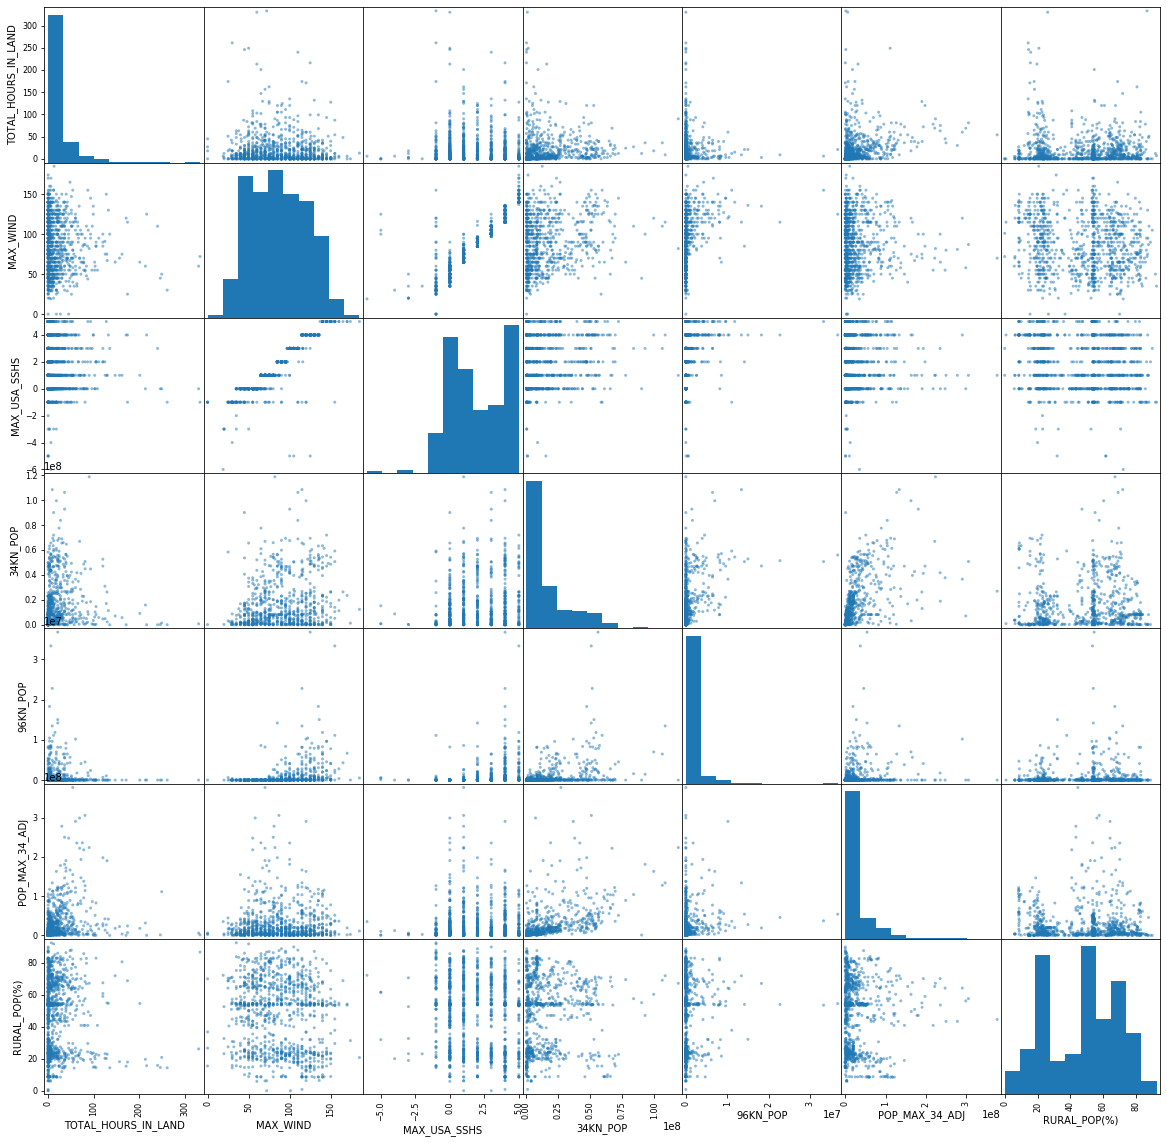

In [9]:
attributes = ['TOTAL_HOURS_IN_LAND', 'MAX_WIND', 'MAX_USA_SSHS', '34KN_POP', '96KN_POP', 'POP_MAX_34_ADJ', 'RURAL_POP(%)']
scatter_matrix(df[attributes],figsize=(20,20));

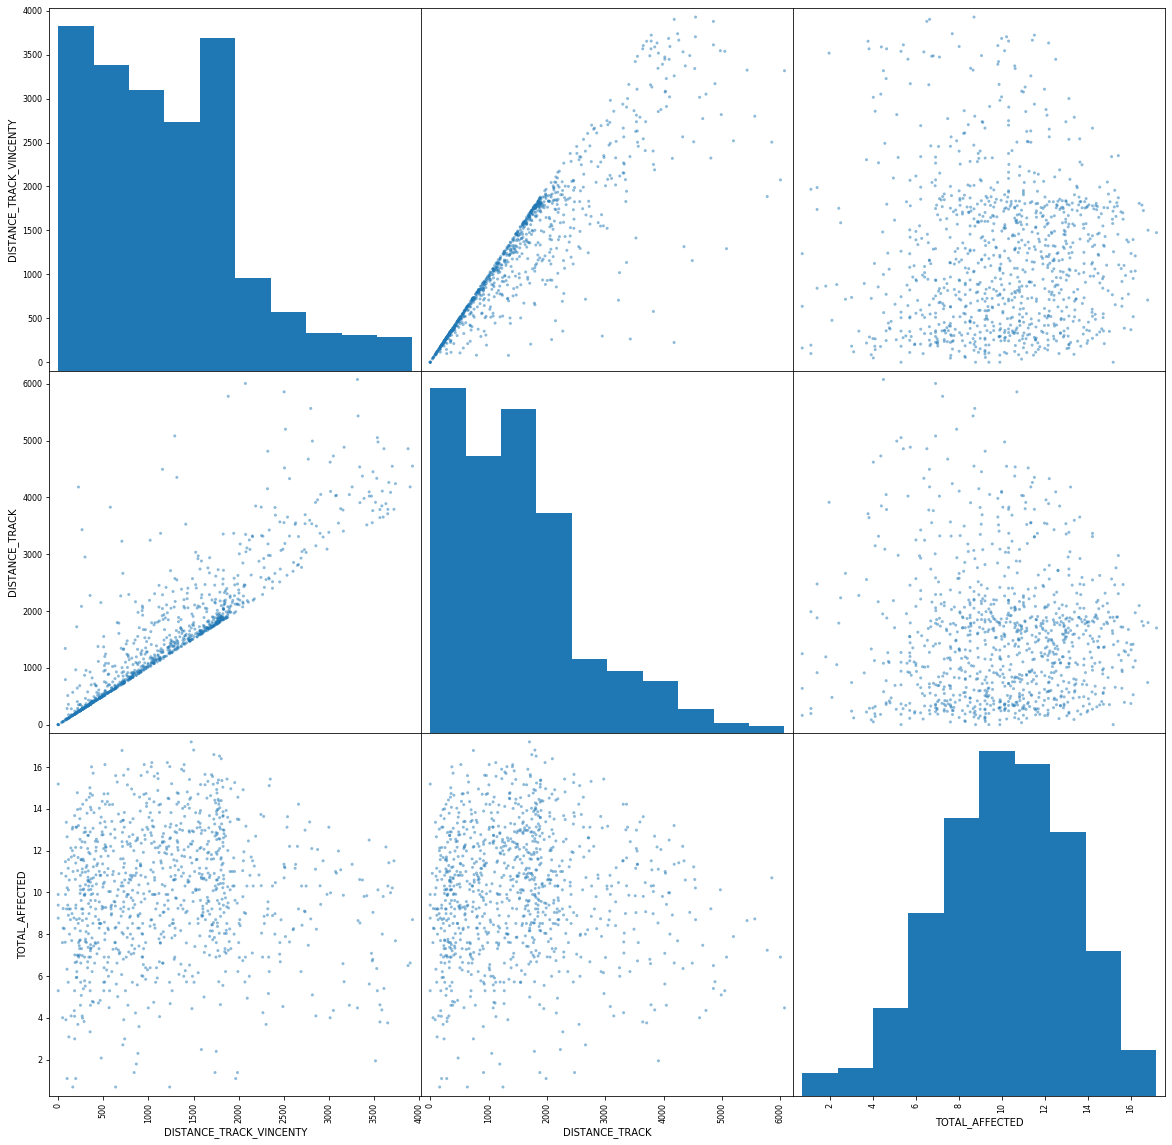

In [10]:
attributes = ['DISTANCE_TRACK_VINCENTY', 'DISTANCE_TRACK', 'TOTAL_AFFECTED']
scatter_matrix(df_trans[attributes],figsize=(20,20));

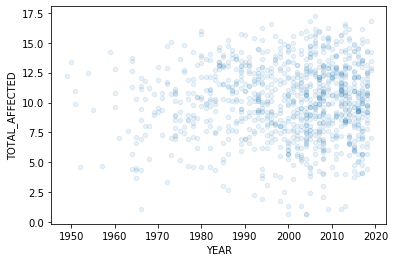

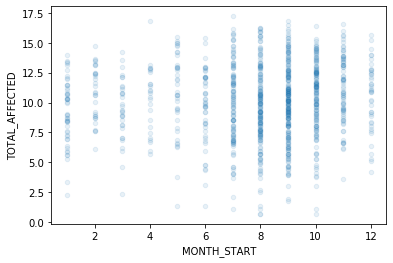

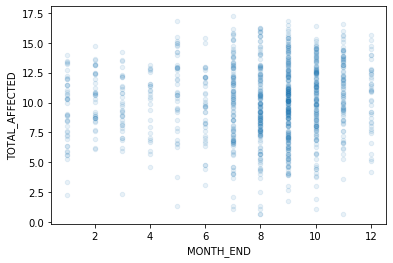

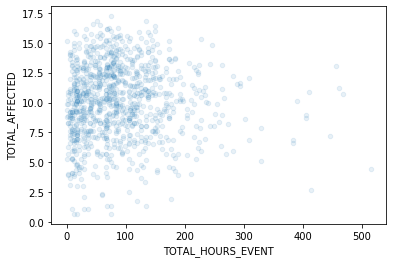

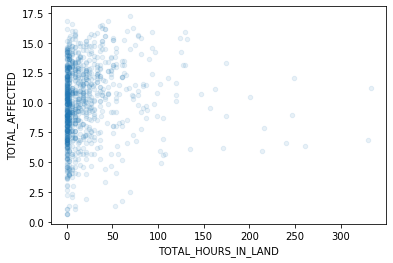

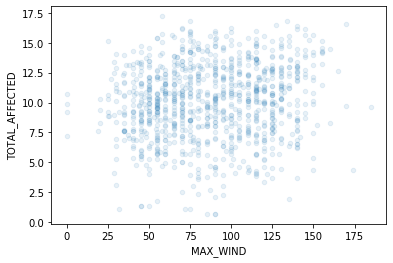

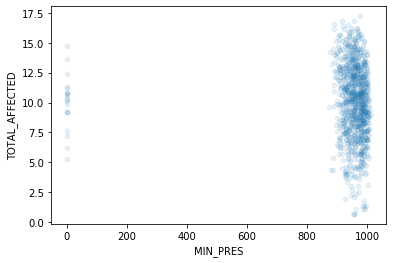

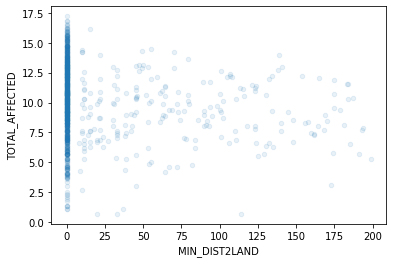

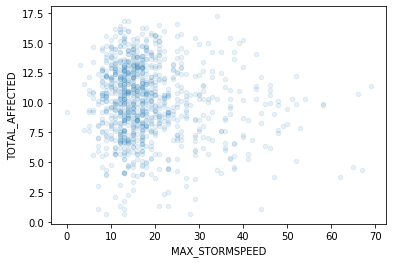

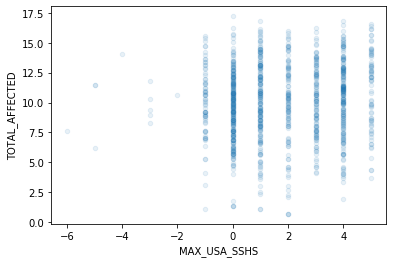

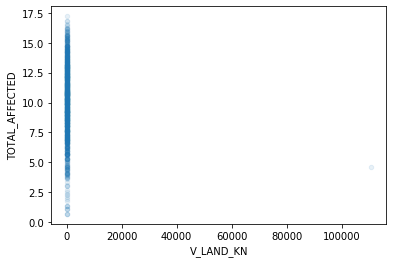

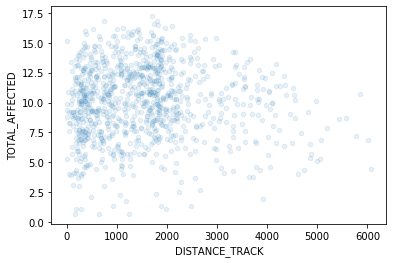

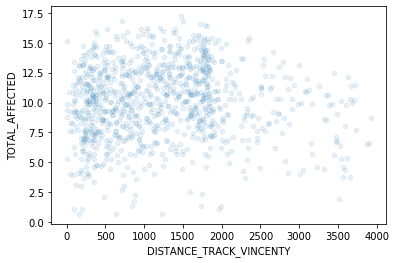

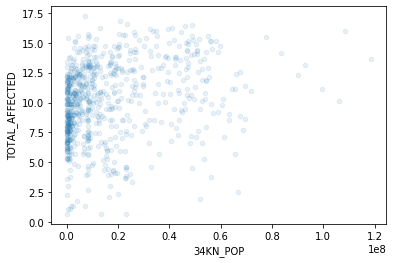

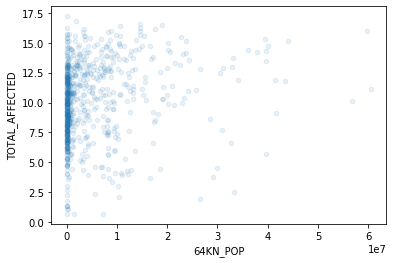

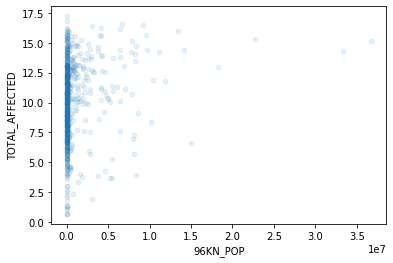

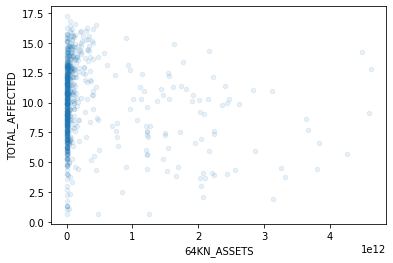

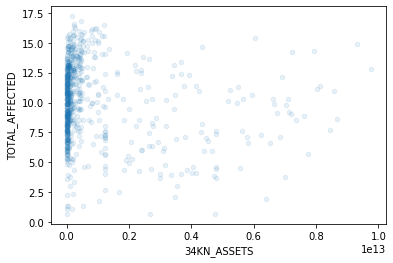

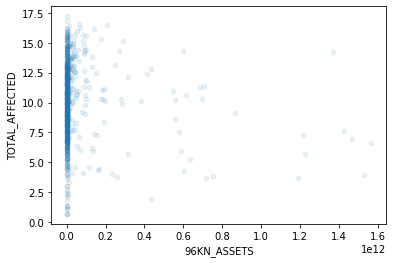

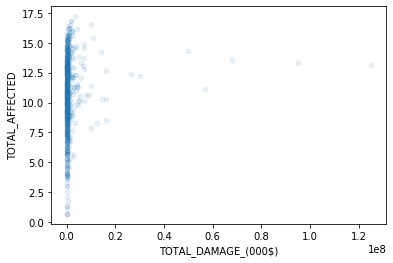

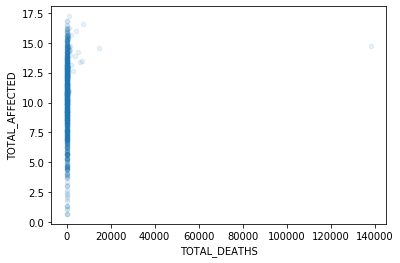

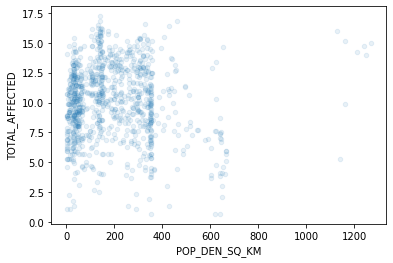

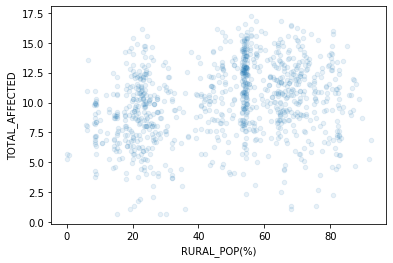

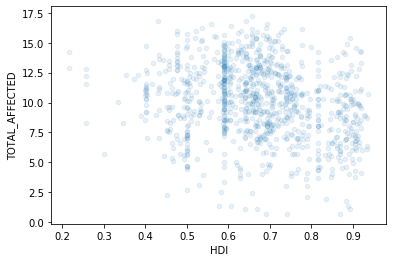

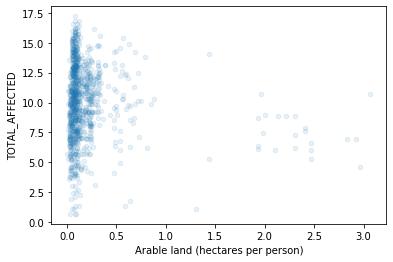

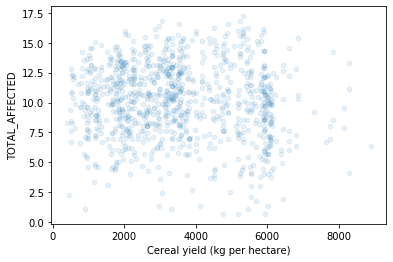

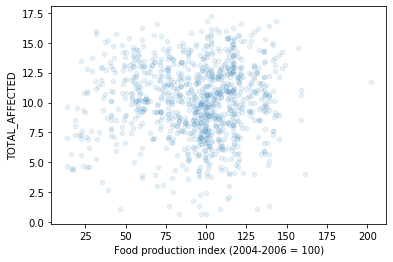

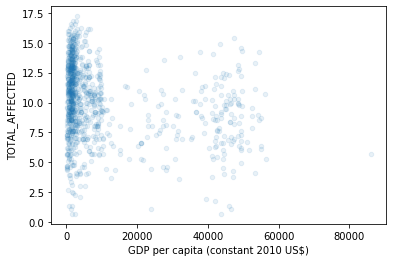

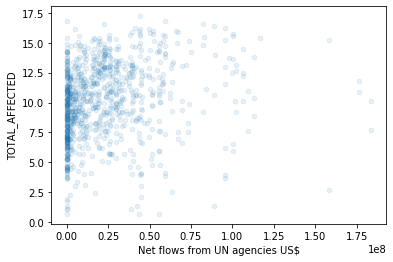

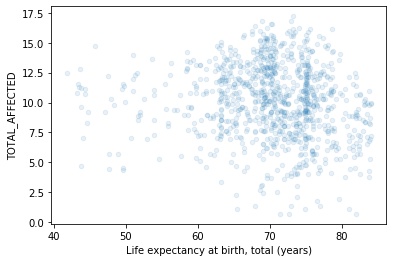

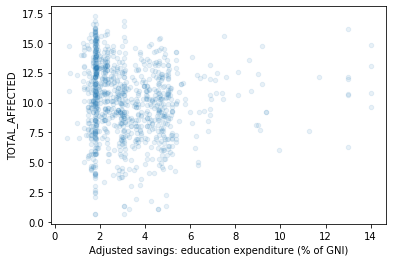

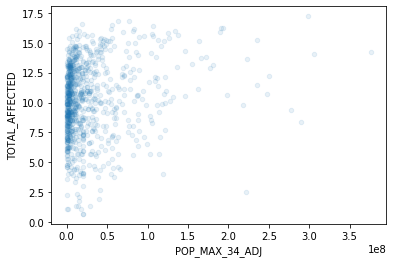

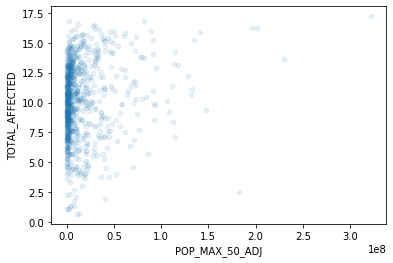

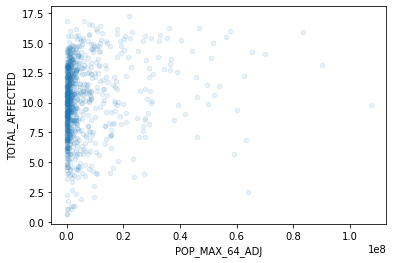

In [11]:
for e in num_features:
    df_trans.plot(kind="scatter", x=e, y="TOTAL_AFFECTED", alpha=0.1);

In [12]:
# categorical features
for e in ['BASIN', 'GENERAL_CATEGORY', 'MAX_USA_SSHS_INLAND']:
    print(df_trans[e].value_counts())
    print(len(df_trans[e]))
    print("\n")

WP     539
NAm    212
SI      86
SP      60
EP      55
NI      39
Name: BASIN, dtype: int64
991


TS       249
Cat 4    196
Cat 1    195
Cat 3    124
Cat 2    120
Cat 5     74
TD        33
Name: GENERAL_CATEGORY, dtype: int64
991


0             272
No landing    218
1             161
-1             97
2              91
3              80
4              43
5               9
-4              8
-3              7
-2              2
-5              2
-6              1
Name: MAX_USA_SSHS_INLAND, dtype: int64
991




### 3. Transform data

In [13]:
num_features += ['Income_level_Final']
cat_features.remove('Income_level_Final')

In [14]:
# custom transformers

class DataFrameSelector(BaseEstimator, TransformerMixin):
    # selects a slice of the dataset based on feature_names
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[set(X.columns).intersection(self.feature_names)]


class TransformerCat(BaseEstimator, TransformerMixin):
    # transforms categorical features
    
    def __init__(self):
        self.features_to_keep = []
        self.features_to_drop = []

    def fit(self, X, y=None):
        self.features_to_keep = ['BASIN', 'SUB BASIN', 'GENERAL_CATEGORY', 'MAX_USA_SSHS_INLAND', 'NATURE']
        
        self.features_to_drop = ['SID', 'NAME', 'ISO', 'DATE_START', 
                                 'DATE_END', 'COORDS', 'COORDS_MAX_WINDS', 
                                 'COORDS_MIN_DIST2LAND', 'DATE_LAND_START', 'DATE_LAND_END']
        return self
    
    def get_dummies(self, X):
        MAX_USA_SSHS_INLAND_dummies = pd.get_dummies(X['MAX_USA_SSHS_INLAND'])[['-1', '0', '1', '2', '3', '4', '5', 'No landing']]
        GENERAL_CATEGORY_dummies = pd.get_dummies(X['GENERAL_CATEGORY'])[['Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'Cat 5', 'TS']]
        BASIN_dummies = pd.get_dummies(X['BASIN'])
        SUB_BASIN_dummies = pd.get_dummies(X['SUB BASIN'])[['WP', 'CS', 'SI', 'GM']]
        NATURE_dummies = pd.get_dummies(X['NATURE'])[['TS', 'NR', 'ET']]
        X.drop(columns = ['MAX_USA_SSHS_INLAND', 'GENERAL_CATEGORY', 'BASIN', 'SUB BASIN', 'NATURE'], inplace=True)
        X = pd.concat((X, MAX_USA_SSHS_INLAND_dummies, GENERAL_CATEGORY_dummies, BASIN_dummies, SUB_BASIN_dummies), axis=1)
        return X

    def transform(self, X, y=None):
        X = X.drop(self.features_to_drop, axis = 1)
        X = self.get_dummies(X)
        return X
    
class TransformerNum(BaseEstimator, TransformerMixin):
    # transforms numerical features
    
    def __init__(self):
        self.features_to_keep = []
        self.features_to_drop = []
        self.features_to_log = []

    def fit(self, X, y=None):
        # do not drop ['TOTAL_HOURS_IN_LAND', 'MAX_WIND', 'MAX_STORMSPEED', 'V_LAND_KN', \
        # 'POP_DEN_SQ_KM', 'RURAL_POP(%)', \
        # 'HDI', 'POP_MAX_34', 'POP_MAX_50', 'POP_MAX_64'] based on Arnab's Analysis
        
        
        self.features_to_keep = ['TOTAL_HOURS_IN_LAND', 'MAX_WIND', 'MIN_DIST2LAND', 'V_LAND_KN', 'MAX_USA_SSHS',
                                 'MAX_STORMSPEED', '64KN_ASSETS', 'DISTANCE_TRACK', 'RURAL_POP(%)',
                                 'POP_DEN_SQ_KM','34KN_POP', 'GDP per capita (constant 2010 US$)'
                                 'Life expectancy at birth, total (years)',
                                 'Cereal yield (kg per hectare)',
                                 'Adjusted savings: education expenditure (% of GNI)',
                                 'GDP per capita (constant 2010 US$)',
                                 'Net flows from UN agencies US$',
                                 'Food production index (2004-2006 = 100)',
                                 'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ', 'HDI']
        
        self.features_to_drop = ['YEAR', 'MONTH_START', 'MONTH_END', 'TOTAL_HOURS_EVENT', 
                                 'MIN_PRES', '64KN_POP', '96KN_POP',
                                 'TOTAL_DEATHS', 'DISTANCE_TRACK_VINCENTY', 'TOTAL_DAMAGE_(000$)',
                                 '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS',]
        
        self.features_to_log = ['TOTAL_HOURS_IN_LAND', 'POP_DEN_SQ_KM', '34KN_POP',
                               'POP_MAX_34_ADJ', 'POP_MAX_50_ADJ', 'POP_MAX_64_ADJ',
                               'Net flows from UN agencies US$', 'Adjusted savings: education expenditure (% of GNI)',
                                'Arable land (hectares per person)']

        return self
        
    def _get_log(self, X, f):
        # Xavier code
        X[f] = np.log((X[f] + 1 -  X[f].min()).values)
        return X
    
    def _transform_Income_level_Final(self, X):
        # Arnab code
        unique_list = X['Income_level_Final'].unique()
        incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
        X['Income_level_Final'] = X['Income_level_Final'].apply(lambda x: incomelevel_to_int[x])
        return X
    
    def _transform_MAX_STORMSPEED(self, X):
        X['MAX_STORMSPEED'] = X['MAX_STORMSPEED'].apply(lambda x: x**2)
        return X
    
    """def _transform_assets(self, X):
        X['CALC_assets_emdat'] = X['34KN_ASSETS'] + X['64KN_ASSETS'] + X['96KN_ASSETS']
        X.drop(['64KN_ASSETS', '96KN_ASSETS','96KN_ASSETS'], axis=1, inplace=True)
        return X"""
    
    def _transform_HDI(self, X):
        X['HDI'] = np.sin(X['HDI'])
        return X
    
    def transform(self, X, y=None):
        X = X.drop(self.features_to_drop, axis = 1)
        # X = self._transform_assets(X)
        X = self._transform_MAX_STORMSPEED(X)
        X = self._transform_Income_level_Final(X)
        X = self._transform_HDI(X)
        for f in self.features_to_log:
            X = self._get_log(X, f)
        return X

In [15]:
# preprocess pipeline

preprocess_pipeline = FeatureUnion(transformer_list =[
        ("num_pipeline", Pipeline([
            ('selector', DataFrameSelector(num_features)),
            ('num_transformer', TransformerNum()),
            #('imputer', SimpleImputer(strategy="median")),
            ('knn_imputer', KNNImputer(n_neighbors=5)), 
            #('scaler', StandardScaler()), # decreasing performance
            #('scaler', MinMaxScaler()), # decreasing performance
            # ('normalizer', Normalizer()) # decreasing performance
            # ('uniform_distribution', PowerTransformer(method='yeo-johnson', standardize=True, copy=True)), # decreasing performance
            # ('uniform_distribution', QuantileTransformer(random_state=42)), # decreasing performance
            # ('pca', PCA(0.99)) # decreasing performance
             ])),
        ("cat_pipeline", Pipeline([
            ('selector', DataFrameSelector(cat_features)),
            ('cat_transformer', TransformerCat()),
            #('imputer', SimpleImputer(strategy="most_frequent")),
            #('encoder', OneHotEncoder(handle_unknown='ignore', sparse = False)), # manually doing it with pandas get_dummies
            # ("scaler", StandardScaler()) # decreasing performance
            ]))])

### 4. Model

In [16]:
class ModelEvaluator:
    # evaluates different models using cross validation on the whole dataset
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.mean_scores = dict()
        self.r2_scores = dict()
        
    def evaluate_models(self, models):
        for model_name, model in models.items():
            print(f'***{model_name}***')
            self._evaluate_model(model_name, model)
            print('\n')
            
    def _display_scores(self, scores, r2):
            print("rmse scores:", scores)
            print("rmse scores (mean):", scores.mean())
            print("rmse scores (std deviation):", scores.std())
            print("r2 score:", r2)

    def _evaluate_model(self, model_name, model):
        
        transformed_X = preprocess_pipeline.fit_transform(self.X)
        
        # rmse
        scores = cross_val_score(model, transformed_X, self.y, scoring="neg_mean_squared_error", cv=10)
        tree_rmse_scores = np.sqrt(-scores)
        
        # r2
        y_pred = cross_val_predict(model, transformed_X, self.y)
        r2 = r2_score(self.y, y_pred)
        
        self._display_scores(tree_rmse_scores, r2)
        self.mean_scores[model_name] = tree_rmse_scores.mean()
        self.r2_scores[model_name] = r2
        
    def save_models(self, models):
        for model_name, model in models.items():
            transformed_X = preprocess_pipeline.fit_transform(self.X)
            model.fit(transformed_X, self.y)
            joblib.dump(model, f'./models/{datetime.datetime.now().date()}_bego_{model_name}_{round(self.r2_scores[model_name], 3)}.pkl')


In [17]:
# grid search random_forest

param_grid = [{'max_depth': list(range(10,70,20)), 'n_estimators': list(range(100,2200,500)), 'max_features': [7, 14, 28, 42], 'random_state': [42]}
             #{'bootstrap': [False], 'n_estimators': list(range(10,200,30)), 'max_features': list(range(2, 10, 2)), 'min_samples_leaf':[2,4,6]},
             ]
"""
forest_reg = RandomForestRegressor(random_state=42)
grid_search_forest = GridSearchCV(forest_reg, 
                                  param_grid, 
                                  cv=6, 
                                  scoring='neg_mean_squared_error', 
                                  return_train_score=True, 
                                  iid = True, 
                                  verbose=10)
transformed_X = preprocess_pipeline.fit_transform(X)
grid_search_forest.fit(transformed_X, y)

print(grid_search_forest.score(transformed_X, y_trans))
print(grid_search_forest.best_params_)""";


In [20]:
### evaluate models 

models = {#'forest_1': RandomForestRegressor(max_depth=400, n_estimators=200, random_state=42),
          'forest_1_2': RandomForestRegressor(max_depth=400, n_estimators=200, max_features=9, random_state=42),
          #'forest_2': RandomForestRegressor(max_depth=600, n_estimators=400, random_state=42),
          #'forest_2_2': RandomForestRegressor(max_depth=600, n_estimators=400, max_features=9, random_state=42),
          #'forest_3': RandomForestRegressor(max_depth=1000, n_estimators=500, random_state=42),
          'forest_3_2': RandomForestRegressor(max_depth=1000, n_estimators=500, max_features=9, random_state=42),
          #'forest_grid_search': grid_search_forest.best_estimator_,
          'forest_4': RandomForestRegressor(max_depth=1000, n_estimators=100, max_features=7, random_state=42),
          'forest_grid_search_0105': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=500,
                      max_features=7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False),
          'forest_grid_search_0205': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False),
        'forest_grid_search_0205': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=600, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False),
         }

random_forest_evaluator = ModelEvaluator(X, y_trans)

random_forest_evaluator.evaluate_models(models)

#random_forest_evaluator.save_models(models)


***forest_1_2***
rmse scores: [2.96315265 2.66345541 2.21323637 2.82958329 2.821225   2.58151269
 2.58653827 2.38807601 2.36825337 2.72123394]
rmse scores (mean): 2.6136266989136105
rmse scores (std deviation): 0.22341074260340424
r2 score: 0.25033450983915917


***forest_3_2***
rmse scores: [2.96424428 2.66023739 2.24720617 2.81080642 2.83249851 2.59589318
 2.59044133 2.37203988 2.32716682 2.70849214]
rmse scores (mean): 2.6109026141778777
rmse scores (std deviation): 0.22279019362260494
r2 score: 0.25648049461269273


***forest_4***
rmse scores: [3.00359899 2.64381744 2.24463699 2.87220039 2.85166818 2.58089866
 2.56106193 2.41866276 2.32670383 2.7390093 ]
rmse scores (mean): 2.6242258467173767
rmse scores (std deviation): 0.2348264460726628
r2 score: 0.2527336465009945


***forest_grid_search_0105***
rmse scores: [2.97642964 2.62444344 2.23885626 2.81530202 2.83133305 2.57336931
 2.58062434 2.42405324 2.32891874 2.68240309]
rmse scores (mean): 2.60757331318556
rmse scores (std devia

### 5. H2O AutoML

In [21]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/bego/miniconda3/envs/myenv/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/34/2xnbd_4d62s2hw706x9ptbvh0000gn/T/tmpd230rbfl
  JVM stdout: /var/folders/34/2xnbd_4d62s2hw706x9ptbvh0000gn/T/tmpd230rbfl/h2o_bego_started_from_python.out
  JVM stderr: /var/folders/34/2xnbd_4d62s2hw706x9ptbvh0000gn/T/tmpd230rbfl/h2o_bego_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Madrid
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.11
H2O cluster version age:,5 months and 2 days !!!
H2O cluster name:,H2O_from_python_bego_q9f6p3
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [22]:
X_trans = preprocess_pipeline.fit_transform(X)
X_trans = pd.DataFrame(X_trans)
df = pd.concat((X_trans, y_trans), axis=1)
df.columns = [str(x) for x in df.columns]

# construct H2O dataframe
df = h2o.H2OFrame(df)

# train/test split
splits = df.split_frame(ratios = [0.8], seed = 1)
train = splits[0]
test = splits[1]

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
df.head()

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,TOTAL_AFFECTED
3889.48,0.728411,116,1089,5.26899,16.299,9.90354,14.7461,4173.5,67.79,3,0,0.0537347,77.2,8607.66,1,4.11087,67.6661,15.5741,1.20267,15.0157,99.82,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,12.1759
3596.09,0.728411,116,961,5.42151,17.2689,9.90354,14.7461,4173.5,67.79,3,0,0.0537347,47,8607.66,1,3.09104,67.6661,16.5623,1.20267,16.1369,99.82,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,13.3725
438.215,0.619417,110,289,4.88447,14.3398,9.90354,14.8405,868.3,69.93,3,0,0.0917864,66.23,3796.22,1,1.38629,64.77,14.3385,1.11167,13.9937,132.4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,9.91344
2238.06,0.556361,120,121,4.1545,15.3758,9.90354,16.8341,996.3,25.68,4,0,0.162146,75.35,1059.47,2,3.61092,61.105,14.9163,1.16902,13.9242,119.2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,11.0021
1876.19,0.556361,110,225,4.19147,15.4508,9.90354,17.4055,996.3,25.68,3,0,0.162146,72.41,1059.47,2,2.30259,61.105,14.8414,1.16902,14.5029,110691,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,4.63473
442.38,0.419596,105,49,4.82205,14.7494,9.90354,16.1568,1031,63.29,3,0,0.202046,82.8,993.247,2,2.94444,41.762,13.3891,0.557076,12.6296,117,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,12.4292
1636,0.613117,105,121,2.77384,14.8116,9.90354,15.9384,1104.9,23.69,3,0,0.402932,49.25,3907.49,1,4.48864,57.077,13.5824,1.24253,13.308,119.1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,9.34417
1112.17,0.480303,87,196,4.19298,17.6328,9.90354,15.9132,1192.7,13.36,1,0,0.140602,87.5,192.285,1,3.89182,43.725,16.1327,0.728223,15.1828,61.8,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,4.70953
3309.86,0.728411,155,1444,5.5382,17.3984,9.90354,17.8955,4173.5,67.79,-1,0,0.0537347,37.73,8607.66,1,2.56495,67.6661,17.3022,1.20267,16.257,155.3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,14.221
2121.28,0.480303,87,625,4.23873,17.9321,9.90354,15.9132,1192.7,13.36,1,0,0.140602,83.8,192.285,1,3.3322,43.725,16.956,0.728223,16.288,90.4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,9.62424


In [ ]:
# run AutoML
aml = H2OAutoML(max_runtime_secs = 1200, seed = 42)
aml.train(y = 'TOTAL_AFFECTED', training_frame = train, leaderboard_frame = test)

In [24]:
# run AutoML using cross-validation (100% use of data)
aml2 = H2OAutoML(max_runtime_secs = 1200, seed = 1)
aml2.train(y = 'TOTAL_AFFECTED', training_frame = df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [25]:
# leaderboards
display(aml.leaderboard.head())
display(aml2.leaderboard.head())

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200508_004152,6.38477,2.52681,6.38477,1.96598,0.291379
StackedEnsemble_BestOfFamily_AutoML_20200508_004152,6.42443,2.53465,6.42443,1.97991,0.292169
GBM_grid_1_AutoML_20200508_004152_model_14,6.62145,2.57322,6.62145,2.0129,0.295992
XGBoost_1_AutoML_20200508_004152,6.6989,2.58822,6.6989,1.99843,0.298433
GBM_grid_1_AutoML_20200508_004152_model_8,6.71604,2.59153,6.71604,2.02262,0.297685
GBM_2_AutoML_20200508_004152,6.71948,2.5922,6.71948,2.00867,0.2981
GBM_grid_1_AutoML_20200508_004152_model_18,6.7952,2.60676,6.7952,2.02431,0.30055
XGBoost_2_AutoML_20200508_004152,6.80204,2.60807,6.80204,2.03503,0.297887
GBM_grid_1_AutoML_20200508_004152_model_17,6.82157,2.61181,6.82157,2.02582,0.29916
XGBoost_grid_1_AutoML_20200508_004152_model_6,6.82768,2.61298,6.82768,2.04113,0.299405
